In [1]:
import torch
from torchsummary import summary
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [114]:
train_csv = pd.read_csv("./sales_train.csv", parse_dates=['date'])
print(train_csv.head(10))

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-02-01               0       59    22154      999.00           1.0
1 2013-03-01               0       25     2552      899.00           1.0
2 2013-05-01               0       25     2552      899.00          -1.0
3 2013-06-01               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0
5 2013-10-01               0       25     2564      349.00           1.0
6 2013-02-01               0       25     2565      549.00           1.0
7 2013-04-01               0       25     2572      239.00           1.0
8 2013-11-01               0       25     2572      299.00           1.0
9 2013-03-01               0       25     2573      299.00           3.0


In [3]:
print(train_csv.info())
print(train_csv.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [5]:
# group items by date blocks
df_date = pd.DataFrame(train_csv.groupby(["date_block_num", "shop_id", "item_id", "item_price"], as_index=False)['item_cnt_day'].sum())
df_date.head(5)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,0,32,221.0,6.0
1,0,0,33,347.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,127.0,1.0


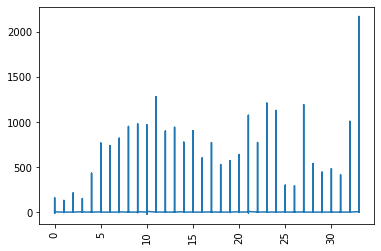

In [7]:
plt.plot( "date_block_num", "item_cnt_day", data = df_date.sort_values(by="date_block_num"))

plt.xticks(rotation=90)

plt.show()

In [8]:
train_grouped = train_csv.sort_values('date_block_num').groupby(['date_block_num'], as_index=True)
train_grouped = train_grouped.agg({'item_cnt_day':sum})
train_grouped.head()

,item_cnt_day
date_block_num,
0,131479.0
1,128090.0
2,147142.0
3,107190.0
4,106970.0


In [9]:
test_proportion = 0.4
train, test = train_test_split(train_grouped, test_size=test_proportion)

print('Train proportion : {:.0f}%'.format((1-test_proportion)*100))
print('Validation proportion : {:.0f}%'.format(test_proportion*100))

Proportion of train_set : 60%
Proportion of valid_set : 40%


In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [11]:
window = 12

train_x,train_y = split_sequence(train.item_cnt_day.values,window)
valid_x,valid_y = split_sequence(test.item_cnt_day.values,window)


In [12]:
class DatasetSales(Dataset):
    def __init__(self,item_group,target):
        self.item_group = item_group
        self.target = target
    
    def __len__(self):
        return len(self.item_group)
    
    def __getitem__(self,idx):
        item = self.item_group[idx]
        label = self.target[idx]
        return item,label

In [104]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv1d(12,64,kernel_size=1)
        self.conv2 = nn.Conv1d(64,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64*2,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x
    

In [105]:
## preparing train and test
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = ConvNet().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [106]:
summary(cnn,[12,1])

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 64, 1]               832
├─ReLU: 1-2                              [-1, 64, 1]               --
├─Conv1d: 1-3                            [-1, 64, 1]               4,160
├─ReLU: 1-4                              [-1, 64, 1]               --
├─Linear: 1-5                            [-1]                      6,450
├─ReLU: 1-6                              [-1]                      --
├─Linear: 1-7                            [-1]                      51
Total params: 11,493
Trainable params: 11,493
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 64, 1]               832
├─ReLU: 1-2                              [-1, 64, 1]               --
├─Conv1d: 1-3                            [-1, 64, 1]               4,160
├─ReLU: 1-4                              [-1, 64, 1]               --
├─Linear: 1-5                            [-1]                      6,450
├─ReLU: 1-6                              [-1]                      --
├─Linear: 1-7                            [-1]                      51
Total params: 11,493
Trainable params: 11,493
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

In [107]:
trainset = DatasetSales(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
validset = DatasetSales(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=2,shuffle=False)
validationloader = torch.utils.data.DataLoader(trainset,batch_size=2,shuffle=False)


In [108]:
dataset_loaders = {"train": trainloader, "test": validationloader}


In [109]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    cnn.train()
    
    for idx, (inputs,labels) in enumerate(dataset_loaders["train"]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = cnn(inputs.float())
        loss = criterion(preds,labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(dataset_loaders["train"])
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    cnn.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataset_loaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = cnn(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(dataset_loaders["test"])
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')
        

In [120]:
epochs = 1000
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()

epochs 1/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 2/1000
train_loss 395375392.0
valid_loss 395375378.6875763
epochs 3/1000
train_loss 395375360.0
valid_loss 395375378.6875305
epochs 4/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 5/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 6/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 7/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 8/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 9/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 10/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 11/1000
train_loss 395375392.0
valid_loss 395375378.6875458
epochs 12/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 13/1000
train_loss 395375392.0
valid_loss 395375378.6875458
epochs 14/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 15/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epoc

/Users/clemencevast/opt/anaconda3/envs/pytorch_lab/lib/python3.6/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train_loss 395375392.0
valid_loss 395375378.6875305
epochs 18/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 19/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 20/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 21/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 22/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 23/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 24/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 25/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 26/1000
train_loss 395375392.0
valid_loss 395375378.68751526
epochs 27/1000
train_loss 395375360.0
valid_loss 395375378.6875305
epochs 28/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 29/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 30/1000
train_loss 395375392.0
valid_loss 395375378.6875305
epochs 31/1000
train_loss 395375392.0
valid_loss 395375378.6875
epochs 32/10

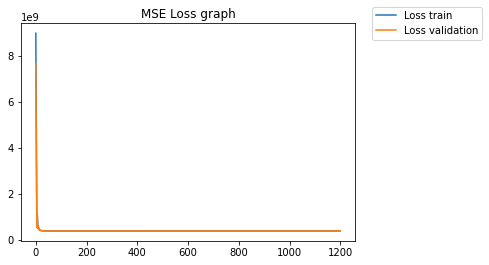

In [121]:
plt.plot(train_losses,label='Loss train')
plt.plot(valid_losses,label='Loss validation')
plt.title('MSE Loss graph')
plt.legend(bbox_to_anchor=(1.05, 1), loc= 'center left', borderaxespad=0.)
plt.show()

In [122]:
target_x , target_y = split_sequence(train.item_cnt_day.values,window)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)
print(train.shape[0])

cnn.eval()
prediction = []
batch_size = 2
iterations =  int(inputs.shape[0]/2)

for i in range(iterations):
    preds = cnn(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds.detach().numpy())

20


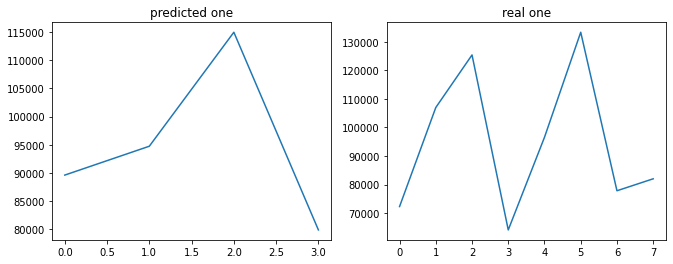

In [123]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()